In [10]:
import random
import imageio
import numpy as np
import tensorflow as tf

print(tf.__version__)

%matplotlib inline
import matplotlib.pyplot as plt

2.12.0


# Подготовка датасета

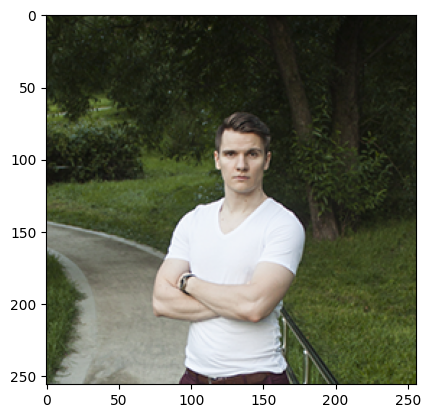

In [2]:
img = imageio.imread_v2('datasets/pics/6.11_me_256.png')
img = img.astype(np.float32) / 255.
_ = plt.imshow(img)

# Загрузка и подготовка карты сегментации человек/фон
То же самое касается файла 'me_gt_256.png'
Это наша Ground-Truth карта сегментации, размеченная кем-то вручную. Значение '0' в ней означает класс "фон", значение '1' - класс
человек

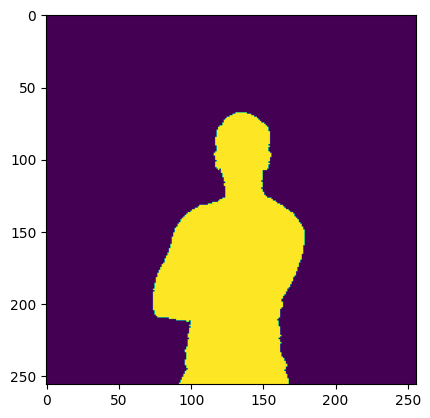

In [3]:
gt = imageio.imread_v2('datasets/pics/6.11_me_gt_256.png')
gt = gt.astype(np.float32) / 255.
gt = np.mean(gt, axis=2)[..., None]
_ = plt.imshow(gt[..., 0])

# Подготовка обучающего датасета
Наша цель создать пайплайн для обучения FCN модели, включая данные, модель, лосс и т.д.
Поэтому для простоты эксперемента возьмем очень простой датасет, состоящий из двух изображений: загруженная карта и отраженная копия.
Индексирование '::-1' означает взять элементы в обратном порядке.
При обучении на таком маленьком датасете модель переобучится, но в данном примере нас это не будет беспокоить. Наша цель - отладить 
пайплайн, поэтому тестировать будем на этом же датасете, на котором и обучались.

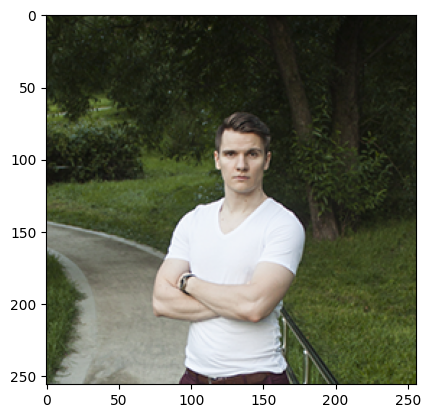

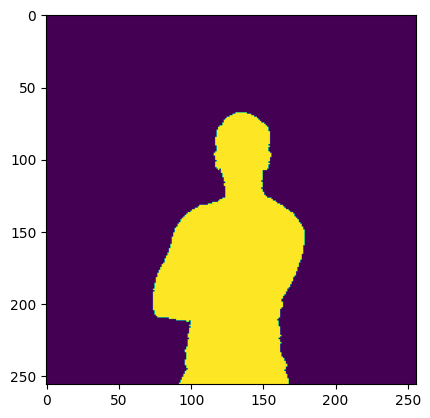

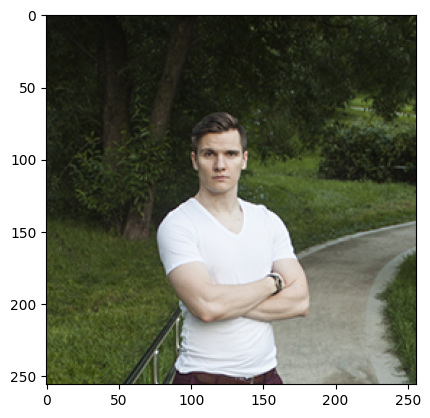

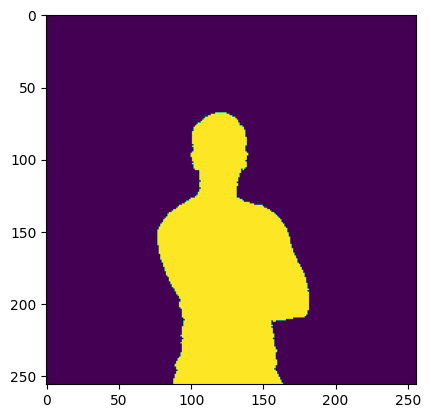

(<matplotlib.image.AxesImage at 0x1247d1370>, None)

In [4]:
train_x = np.stack((img, img[:, ::-1,:]))
train_y = np.stack((gt, gt[:,::-1,:]))

plt.imshow(train_x[0]), plt.show()
plt.imshow(train_y[0][...,0]), plt.show()
plt.imshow(train_x[1]), plt.show()
plt.imshow(train_y[1][...,0]), plt.show()

# Пайплайн обучения FCN

#### Создание FCN модели

In [15]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation=None)
        self.pool = tf.keras.layers.MaxPool2D((2, 2))
        
    def call(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.pool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.pool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = tf.image.resize(out, (x.shape[1], x.shape[2]), tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out

model = Model()

In [17]:
NUM_EPOCHS = 100

In [18]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)

Epoch 1/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0047
Epoch 2/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0043
Epoch 3/100
2/2 [==============================] - 0s 30ms/step - loss: 0.0042
Epoch 4/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0042
Epoch 5/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0042
Epoch 6/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0041
Epoch 7/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0045
Epoch 8/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0041
Epoch 9/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0042
Epoch 10/100
2/2 [==============================] - 0s 30ms/step - loss: 0.0040
Epoch 11/100
2/2 [==============================] - 0s 30ms/step - loss: 0.0042
Epoch 12/100
2/2 [==============================] - 0s 30ms/step - loss: 0.0040
Epoch 13/100
2/2 [==============================]

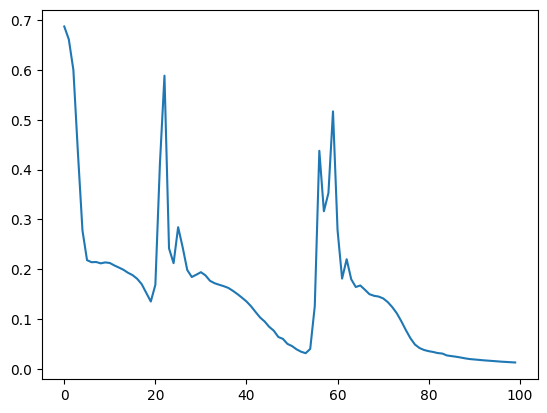

In [21]:
history = model.fit(train_x, train_y, batch_size=1, epochs=NUM_EPOCHS)
plt.plot(hist.history['loss'])

# результат предсказания на входной картинке

1/1 [==============================] - 0s 85ms/step


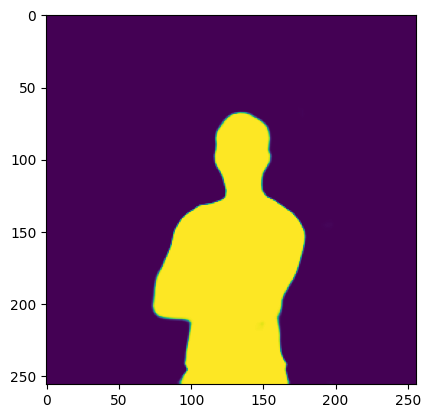

In [20]:
out = model.predict(img[None, ...])[0, ...]
_ = plt.imshow(out[..., 0])

# Результат предсказания для всех картинок

1/1 [==============================] - 0s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


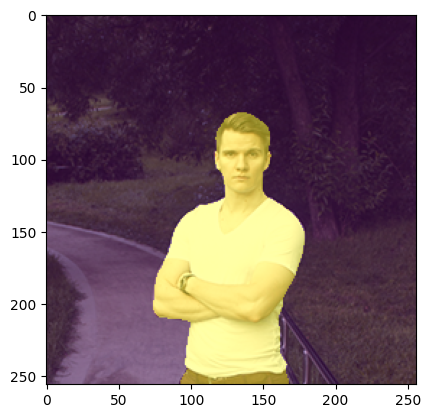

1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


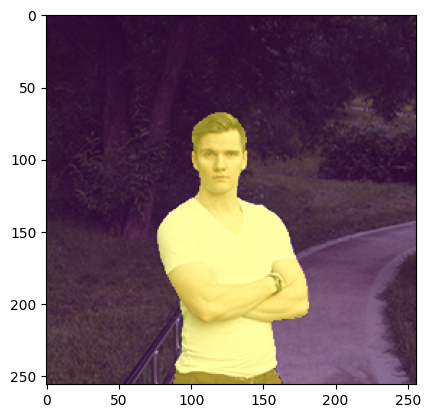

In [23]:
for sample in train_x:
    out = model.predict(sample[None, ...])
    seg_map = (out[0, ..., 0]>.5).astype(np.float32)
    seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
    plt.imshow(sample*.6 + seg_map_clr*.5)
    plt.show()